Importing Libraries and Starting PySpark Session

In [ ]:
print("Name: Harish P")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import uniform

Name: Harish P


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col, count, when, isnan, isnull,lit
from pyspark.sql.functions import median as _median
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.sql.types import StructType, StructField, FloatType
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
spark = SparkSession.builder.appName("Internship").getOrCreate()

Loading Datasets

In [ ]:
dftr = spark.read.csv(r"/content/train.csv", header=True, inferSchema=True)
dftr = dftr.withColumn("area_code", col("area_code").substr(11, 100))
dftr.show(5)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-----+
|state|account_length|area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churn|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+--------------------

In [ ]:
dfte = spark.read.csv(r"/content/test.csv", header=True, inferSchema=True)
dfte = dfte.withColumn("area_code", col("area_code").substr(11, 100))
dfte.show(5)

+---+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+
| id|state|account_length|area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|
+---+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+--------------------

**Start of Explotary Data Analysis**

**Total information about the data sets**

1. No: of Rows.
2. No: of Colums.
3. No: of Null Values
4. No: of Distinct Values

In [ ]:
# Much better than df.schema

def information(df):
    num_rows = df.count()
    num_cols = len(df.columns)

    column_info = [(col_name, dftr.schema[col_name].dataType) for col_name in df.columns]
    missing_info = [(col_name, dftr.where(col(col_name).isNull() | isnan(col(col_name))).count()) for col_name in dftr.columns]
    distinct_info = [(col_name, dftr.select(col_name).distinct().count()) for col_name in dftr.columns]

    print(f"Number of Rows: {num_rows}")
    print(f"Number of Columns: {num_cols}")
    print("\nColumn Information:")
    for col_name, data_type in column_info:
        print(f"- {col_name}: {data_type}")
    print("\nMissing Values:")
    for col_name, missing_count in missing_info:
        print(f"- {col_name}: {missing_count} missing values")
    print("\nDistinct Values:")
    for col_name, distinct_count in distinct_info:
        print(f"- {col_name}: {distinct_count} distinct values")

information(dftr)

Number of Rows: 4250
Number of Columns: 20

Column Information:
- state: StringType()
- account_length: IntegerType()
- area_code: StringType()
- international_plan: StringType()
- voice_mail_plan: StringType()
- number_vmail_messages: IntegerType()
- total_day_minutes: DoubleType()
- total_day_calls: IntegerType()
- total_day_charge: DoubleType()
- total_eve_minutes: DoubleType()
- total_eve_calls: IntegerType()
- total_eve_charge: DoubleType()
- total_night_minutes: DoubleType()
- total_night_calls: IntegerType()
- total_night_charge: DoubleType()
- total_intl_minutes: DoubleType()
- total_intl_calls: IntegerType()
- total_intl_charge: DoubleType()
- number_customer_service_calls: IntegerType()
- churn: StringType()

Missing Values:
- state: 0 missing values
- account_length: 0 missing values
- area_code: 0 missing values
- international_plan: 0 missing values
- voice_mail_plan: 0 missing values
- number_vmail_messages: 0 missing values
- total_day_minutes: 0 missing values
- total_d

In [ ]:
def information(df):
    num_rows = df.count()
    num_cols = len(df.columns)

    column_info = [(col_name, df.schema[col_name].dataType) for col_name in df.columns]
    missing_info = [(col_name, df.where(col(col_name).isNull() | isnan(col(col_name))).count()) for col_name in df.columns]
    distinct_info = [(col_name, df.select(col_name).distinct().count()) for col_name in df.columns]

    print(f"Number of Rows: {num_rows}")
    print(f"Number of Columns: {num_cols}")
    print("\nColumn Information:")
    for col_name, data_type in column_info:
        print(f"- {col_name}: {data_type}")
    print("\nMissing Values:")
    for col_name, missing_count in missing_info:
        print(f"- {col_name}: {missing_count} missing values")
    print("\nDistinct Values:")
    for col_name, distinct_count in distinct_info:
        print(f"- {col_name}: {distinct_count} distinct values")

information(dfte)

Number of Rows: 750
Number of Columns: 20

Column Information:
- id: IntegerType()
- state: StringType()
- account_length: IntegerType()
- area_code: StringType()
- international_plan: StringType()
- voice_mail_plan: StringType()
- number_vmail_messages: IntegerType()
- total_day_minutes: DoubleType()
- total_day_calls: IntegerType()
- total_day_charge: DoubleType()
- total_eve_minutes: DoubleType()
- total_eve_calls: IntegerType()
- total_eve_charge: DoubleType()
- total_night_minutes: DoubleType()
- total_night_calls: IntegerType()
- total_night_charge: DoubleType()
- total_intl_minutes: DoubleType()
- total_intl_calls: IntegerType()
- total_intl_charge: DoubleType()
- number_customer_service_calls: IntegerType()

Missing Values:
- id: 0 missing values
- state: 0 missing values
- account_length: 0 missing values
- area_code: 0 missing values
- international_plan: 0 missing values
- voice_mail_plan: 0 missing values
- number_vmail_messages: 0 missing values
- total_day_minutes: 0 miss

Univariate Analysis

In [ ]:
# It is better to convert our pyspark data frame to pandas dataframe and then do the analysis
pdftr=dftr.toPandas()

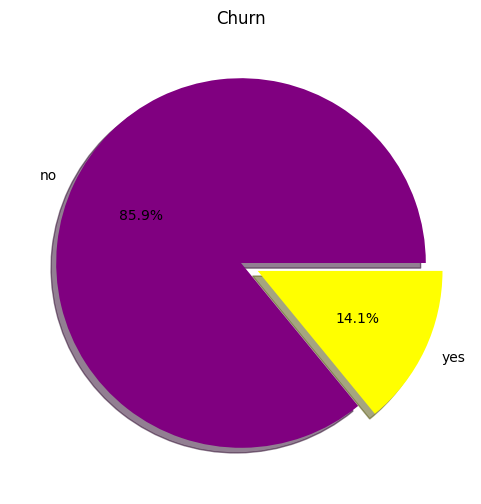

In [ ]:
# 1. Pie Plot
x = pdftr.churn.unique().tolist()

fig = plt.figure(figsize=(6, 6))
plt.pie(pdftr.churn.value_counts(),[0,0.1],labels = x,autopct ='%1.1f%%',shadow = True,colors = ['purple','yellow',])
plt.title('Churn')
plt.show()

<ipython-input-91-d0f43917de58>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pdftr['total_intl_charge'])


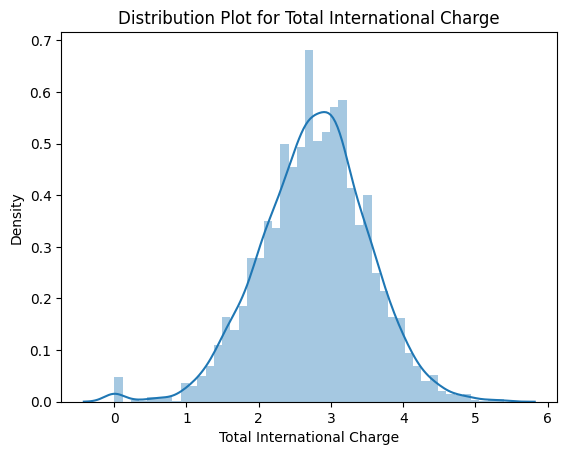

In [ ]:
# 2. Dist Plot

sns.distplot(pdftr['total_intl_charge'])
plt.title('Distribution Plot for Total International Charge')
plt.xlabel('Total International Charge')
plt.show()

Bivariate Analysis

In [ ]:
x=pdftr['total_day_minutes']
y=pdftr['total_eve_minutes']

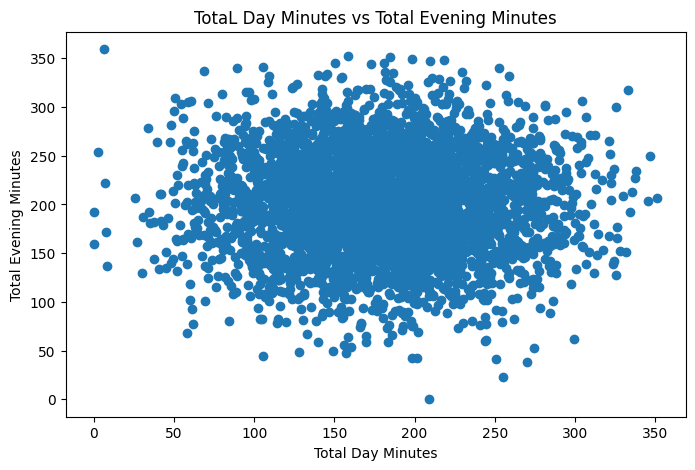

In [ ]:
# 1. Joint Plot

plt.figure(figsize=(8,5))
plt.scatter(x,y)
plt.title('TotaL Day Minutes vs Total Evening Minutes')
plt.xlabel('Total Day Minutes')
plt.ylabel('Total Evening Minutes')
plt.show()

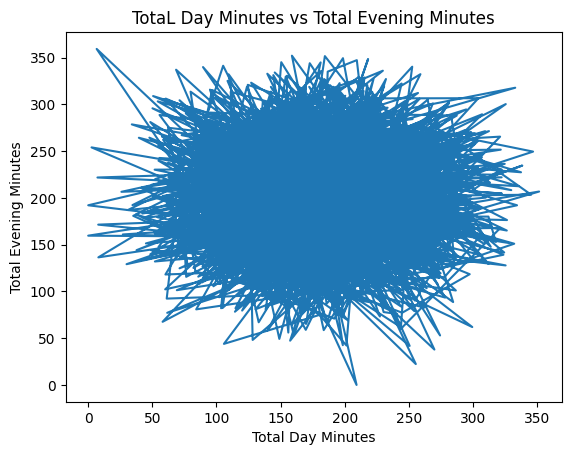

In [ ]:
# 2. Scatter Plot

plt.plot(x,y)
plt.title('TotaL Day Minutes vs Total Evening Minutes')
plt.xlabel('Total Day Minutes')
plt.ylabel('Total Evening Minutes')
plt.show()

Multivariate Analysis

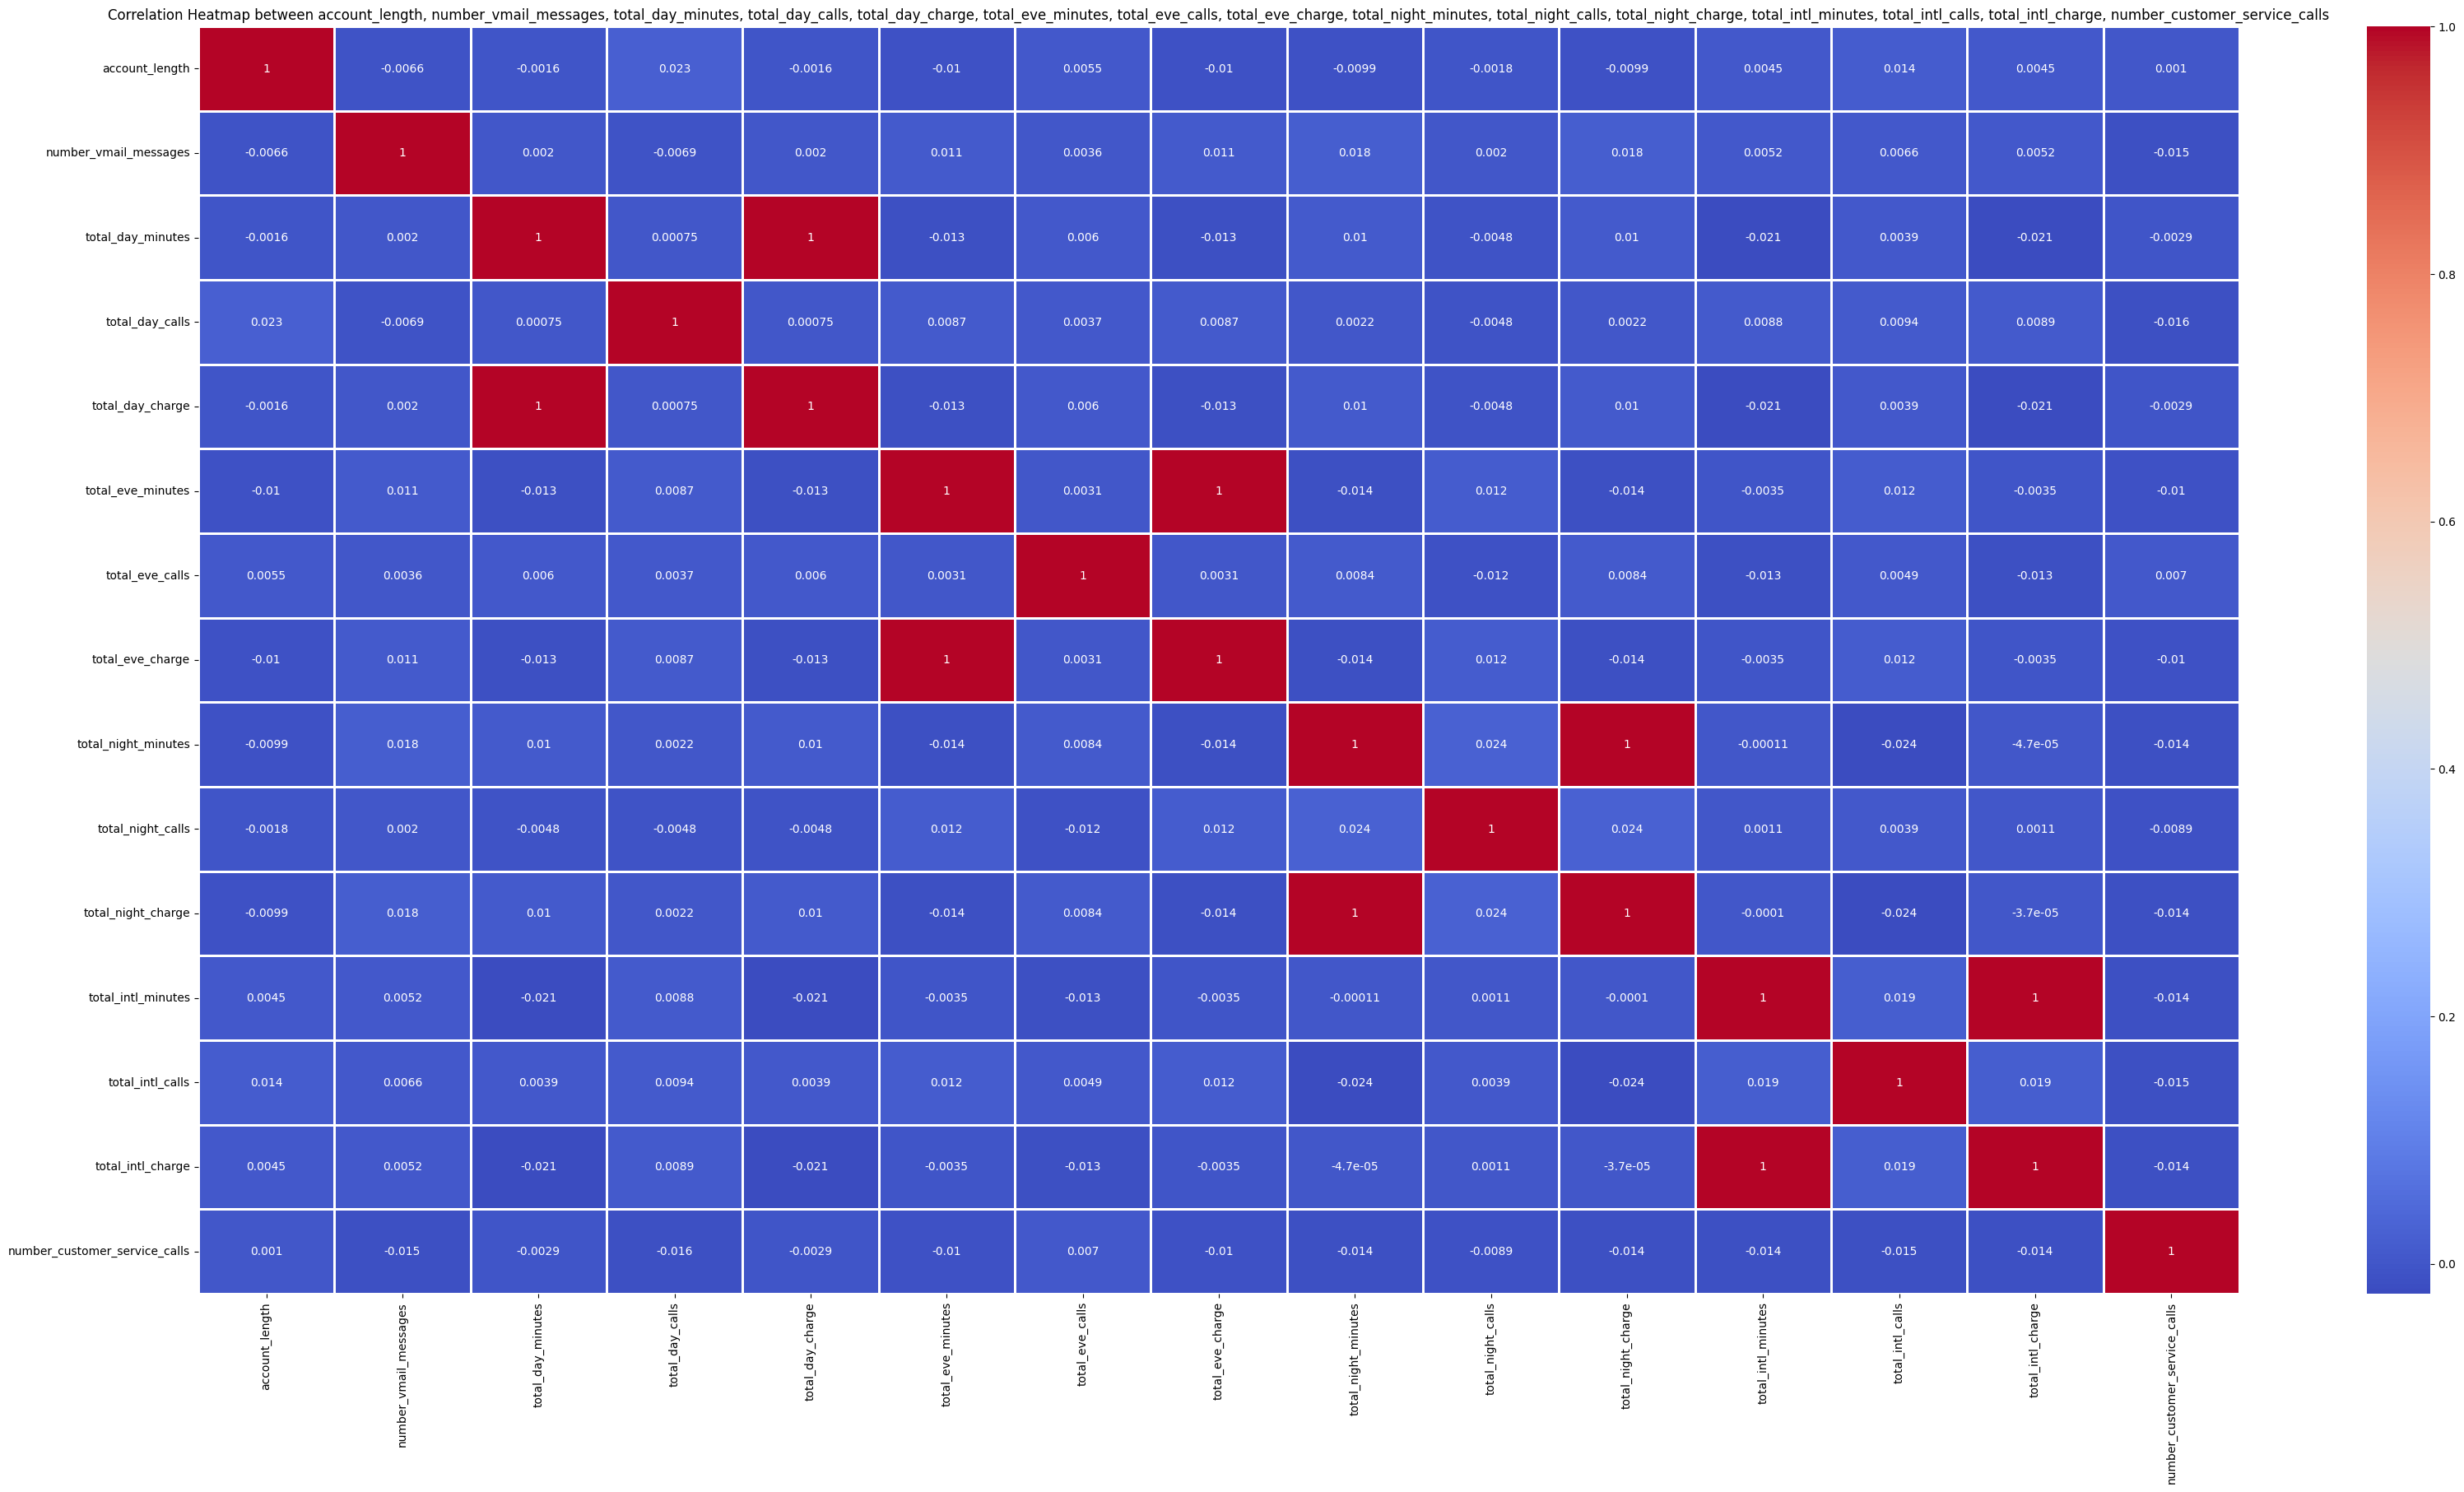

In [ ]:
# 1. Heat Map: Before the Outlier Removal to check the Correlation

l=pdftr.select_dtypes(include=['int','float'])
plt.figure(figsize=(40,20))
sns.heatmap(l.corr(), annot=True, cmap='coolwarm', linewidths=1)
plt.title(f'Correlation Heatmap between {", ".join(l)}')
plt.show()

Outlier Indentification and Removal

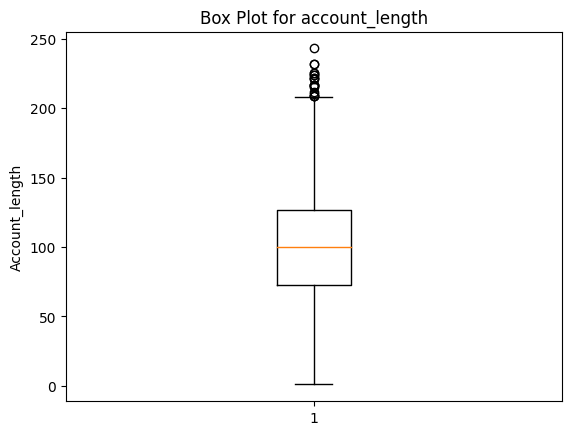

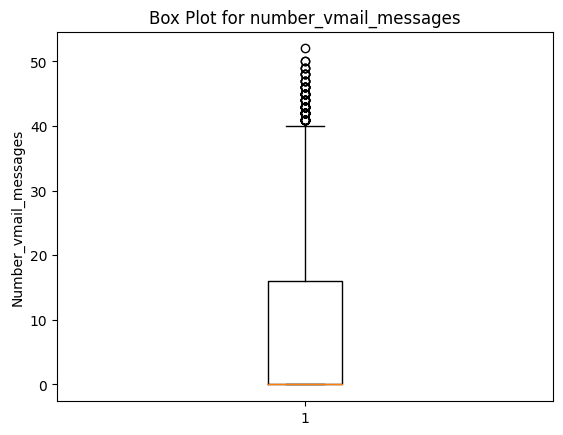

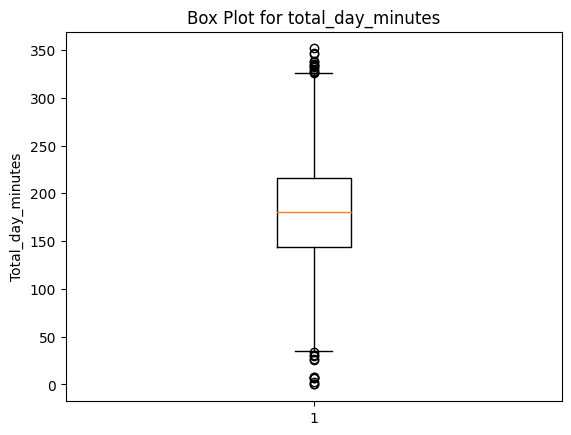

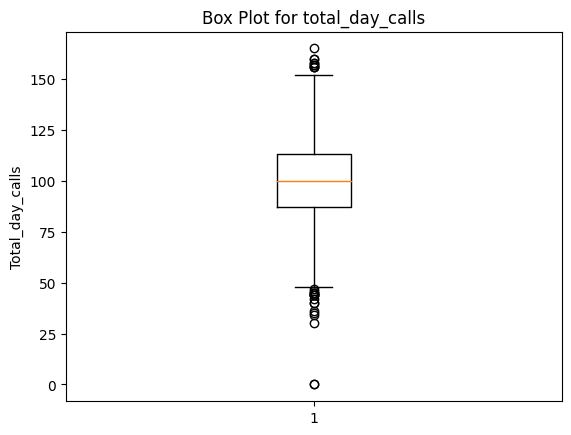

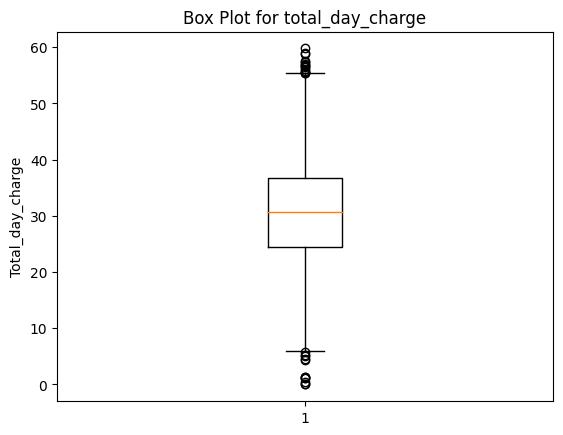

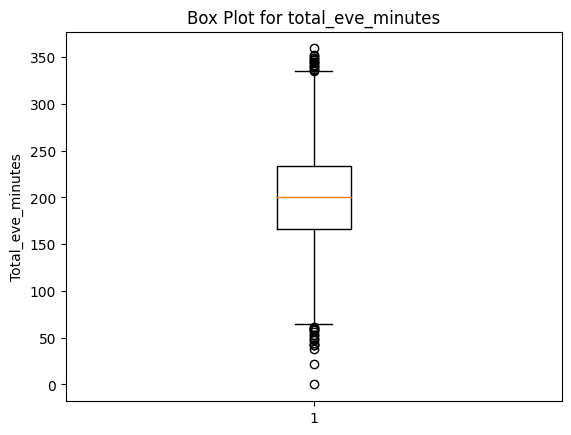

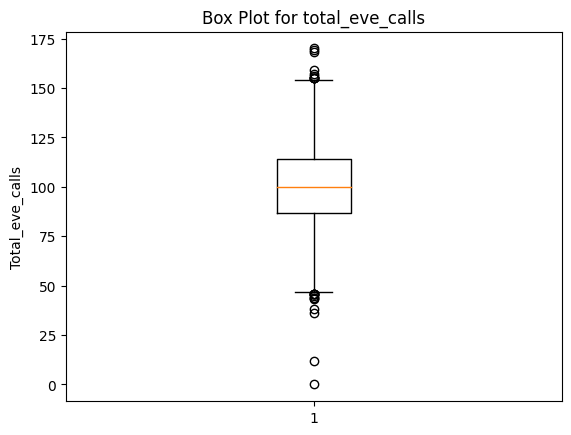

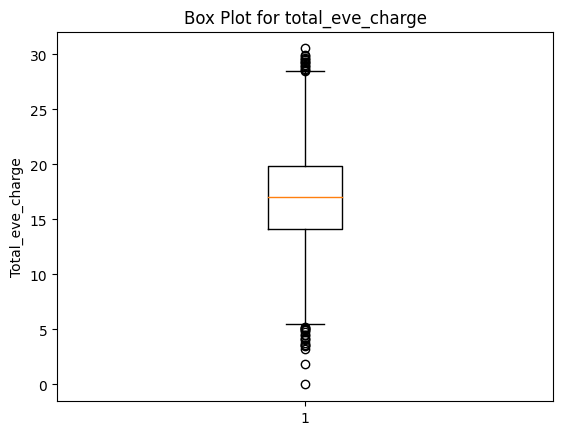

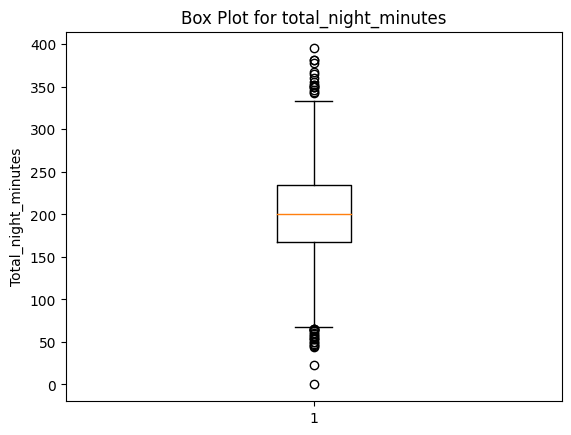

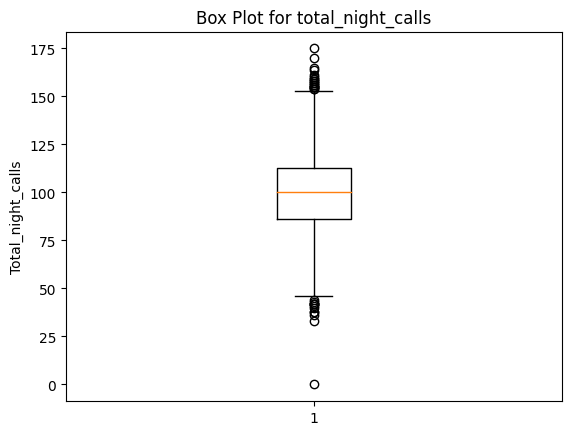

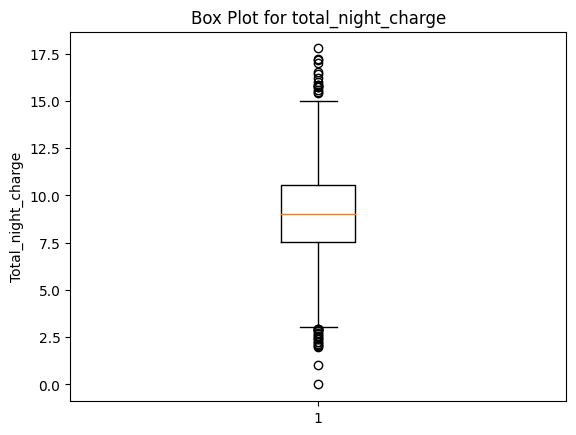

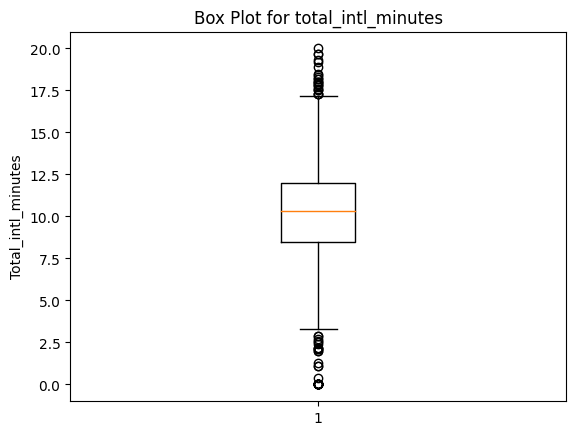

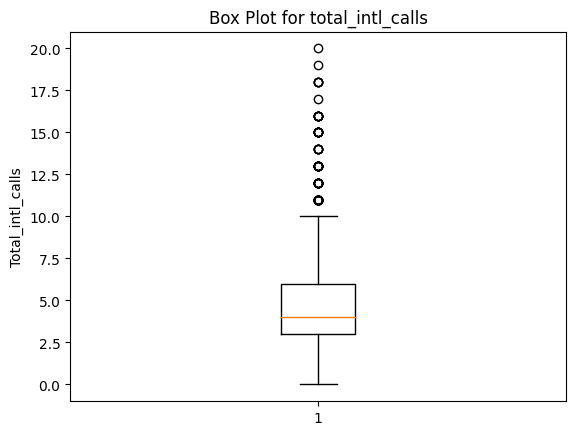

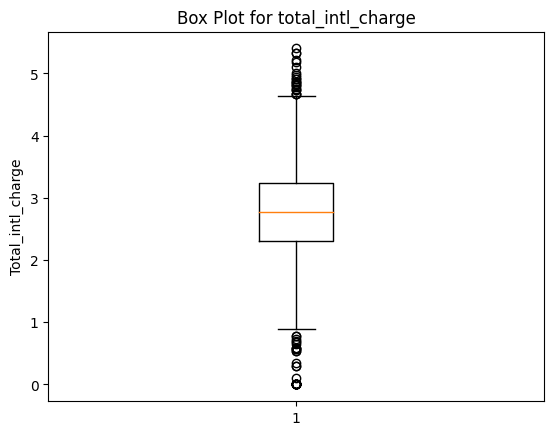

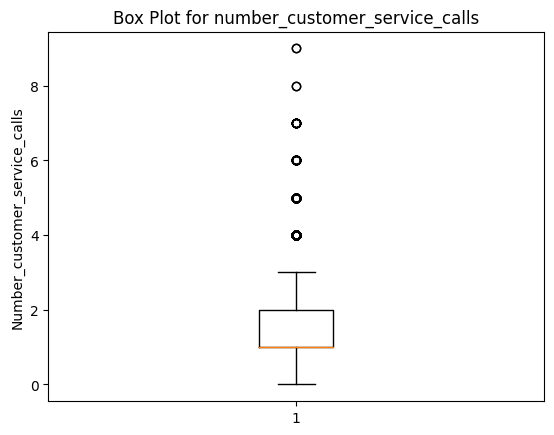

In [ ]:
for i in pdftr.select_dtypes(include=['int','float']).columns:
    plt.boxplot(pdftr[i])
    plt.title('Box Plot for {}'.format(i))
    plt.ylabel(i.capitalize())
    plt.show()

In [ ]:
x=pdftr.select_dtypes(include=['int','float']).columns
for i in x:
  median= dftr.select(_median(col(i)).alias('median')).collect()
  median = median[0]['median']
  print(i,median)

account_length 100.0
number_vmail_messages 0.0
total_day_minutes 180.45
total_day_calls 100.0
total_day_charge 30.68
total_eve_minutes 200.7
total_eve_calls 100.0
total_eve_charge 17.06
total_night_minutes 200.45
total_night_calls 100.0
total_night_charge 9.02
total_intl_minutes 10.3
total_intl_calls 4.0
total_intl_charge 2.78
number_customer_service_calls 1.0


In [ ]:
def count_outliers_iqr(df, column_name):
    quantiles = df.approxQuantile(column_name, [0.25, 0.75], 0.01)
    q1 = quantiles[0]
    q3 = quantiles[1]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers_count = df.filter((col(column_name) < lower_bound) | (col(column_name) > upper_bound)).count()
    return outliers_count

outliers_counts = {}
for column_name in pdftr.select_dtypes(include=['int','float']).columns:
    outliers_counts[column_name] = count_outliers_iqr(dftr, column_name)

for column_name, count in outliers_counts.items():
    print(f"Column '{column_name}': {count} outliers")

Column 'account_length': 21 outliers
Column 'number_vmail_messages': 644 outliers
Column 'total_day_minutes': 29 outliers
Column 'total_day_calls': 26 outliers
Column 'total_day_charge': 29 outliers
Column 'total_eve_minutes': 37 outliers
Column 'total_eve_calls': 29 outliers
Column 'total_eve_charge': 36 outliers
Column 'total_night_minutes': 39 outliers
Column 'total_night_calls': 33 outliers
Column 'total_night_charge': 39 outliers
Column 'total_intl_minutes': 62 outliers
Column 'total_intl_calls': 100 outliers
Column 'total_intl_charge': 62 outliers
Column 'number_customer_service_calls': 335 outliers


In [ ]:
def replace_outliers_with_median(df, column_name):
    quantiles = df.approxQuantile(column_name, [0.25, 0.75], 0.01)
    q1 = quantiles[0]
    q3 = quantiles[1]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    median_value = df.approxQuantile(column_name, [0.5], 0.25)[0]
    df = df.withColumn(
        column_name,
        when(
            (col(column_name) < lower_bound) | (col(column_name) > upper_bound),
            lit(median_value)
        ).otherwise(col(column_name))
    )

    return df

# Iterate through columns and replace outliers with the median for each column
for column_name in pdftr.select_dtypes(include=['int','float']).columns:
    dftr = replace_outliers_with_median(dftr, column_name)

# Show the DataFrame with outliers replaced by the median
dftr.show(5)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-----+
|state|account_length|area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churn|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+--------------------

In [ ]:
def count_outliers_iqr(df, column_name):
    quantiles = df.approxQuantile(column_name, [0.25, 0.75], 0.01)
    q1 = quantiles[0]
    q3 = quantiles[1]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers_count = df.filter((col(column_name) < lower_bound) | (col(column_name) > upper_bound)).count()
    return outliers_count

outliers_counts = {}
for column_name in pdftr.select_dtypes(include=['int','float']).columns:
    outliers_counts[column_name] = count_outliers_iqr(dftr, column_name)

for column_name, count in outliers_counts.items():
    print(f"Column '{column_name}': {count} outliers")

Column 'account_length': 0 outliers
Column 'number_vmail_messages': 467 outliers
Column 'total_day_minutes': 6 outliers
Column 'total_day_calls': 21 outliers
Column 'total_day_charge': 6 outliers
Column 'total_eve_minutes': 8 outliers
Column 'total_eve_calls': 0 outliers
Column 'total_eve_charge': 8 outliers
Column 'total_night_minutes': 4 outliers
Column 'total_night_calls': 0 outliers
Column 'total_night_charge': 4 outliers
Column 'total_intl_minutes': 5 outliers
Column 'total_intl_calls': 185 outliers
Column 'total_intl_charge': 8 outliers
Column 'number_customer_service_calls': 0 outliers


In [ ]:
def information(df):
    num_rows = df.count()
    num_cols = len(df.columns)

    column_info = [(col_name, dftr.schema[col_name].dataType) for col_name in df.columns]
    missing_info = [(col_name, dftr.where(col(col_name).isNull() | isnan(col(col_name))).count()) for col_name in dftr.columns]
    distinct_info = [(col_name, dftr.select(col_name).distinct().count()) for col_name in dftr.columns]

    print(f"Number of Rows: {num_rows}")
    print(f"Number of Columns: {num_cols}")
    print("\nColumn Information:")
    for col_name, data_type in column_info:
        print(f"- {col_name}: {data_type}")
    print("\nMissing Values:")
    for col_name, missing_count in missing_info:
        print(f"- {col_name}: {missing_count} missing values")
    print("\nDistinct Values:")
    for col_name, distinct_count in distinct_info:
        print(f"- {col_name}: {distinct_count} distinct values")

information(dftr)

Number of Rows: 4250
Number of Columns: 20

Column Information:
- state: StringType()
- account_length: DoubleType()
- area_code: StringType()
- international_plan: StringType()
- voice_mail_plan: StringType()
- number_vmail_messages: DoubleType()
- total_day_minutes: DoubleType()
- total_day_calls: DoubleType()
- total_day_charge: DoubleType()
- total_eve_minutes: DoubleType()
- total_eve_calls: DoubleType()
- total_eve_charge: DoubleType()
- total_night_minutes: DoubleType()
- total_night_calls: DoubleType()
- total_night_charge: DoubleType()
- total_intl_minutes: DoubleType()
- total_intl_calls: DoubleType()
- total_intl_charge: DoubleType()
- number_customer_service_calls: DoubleType()
- churn: StringType()

Missing Values:
- state: 0 missing values
- account_length: 0 missing values
- area_code: 0 missing values
- international_plan: 0 missing values
- voice_mail_plan: 0 missing values
- number_vmail_messages: 0 missing values
- total_day_minutes: 0 missing values
- total_day_call

Heat Map

To Check the correaltion after outlier removal

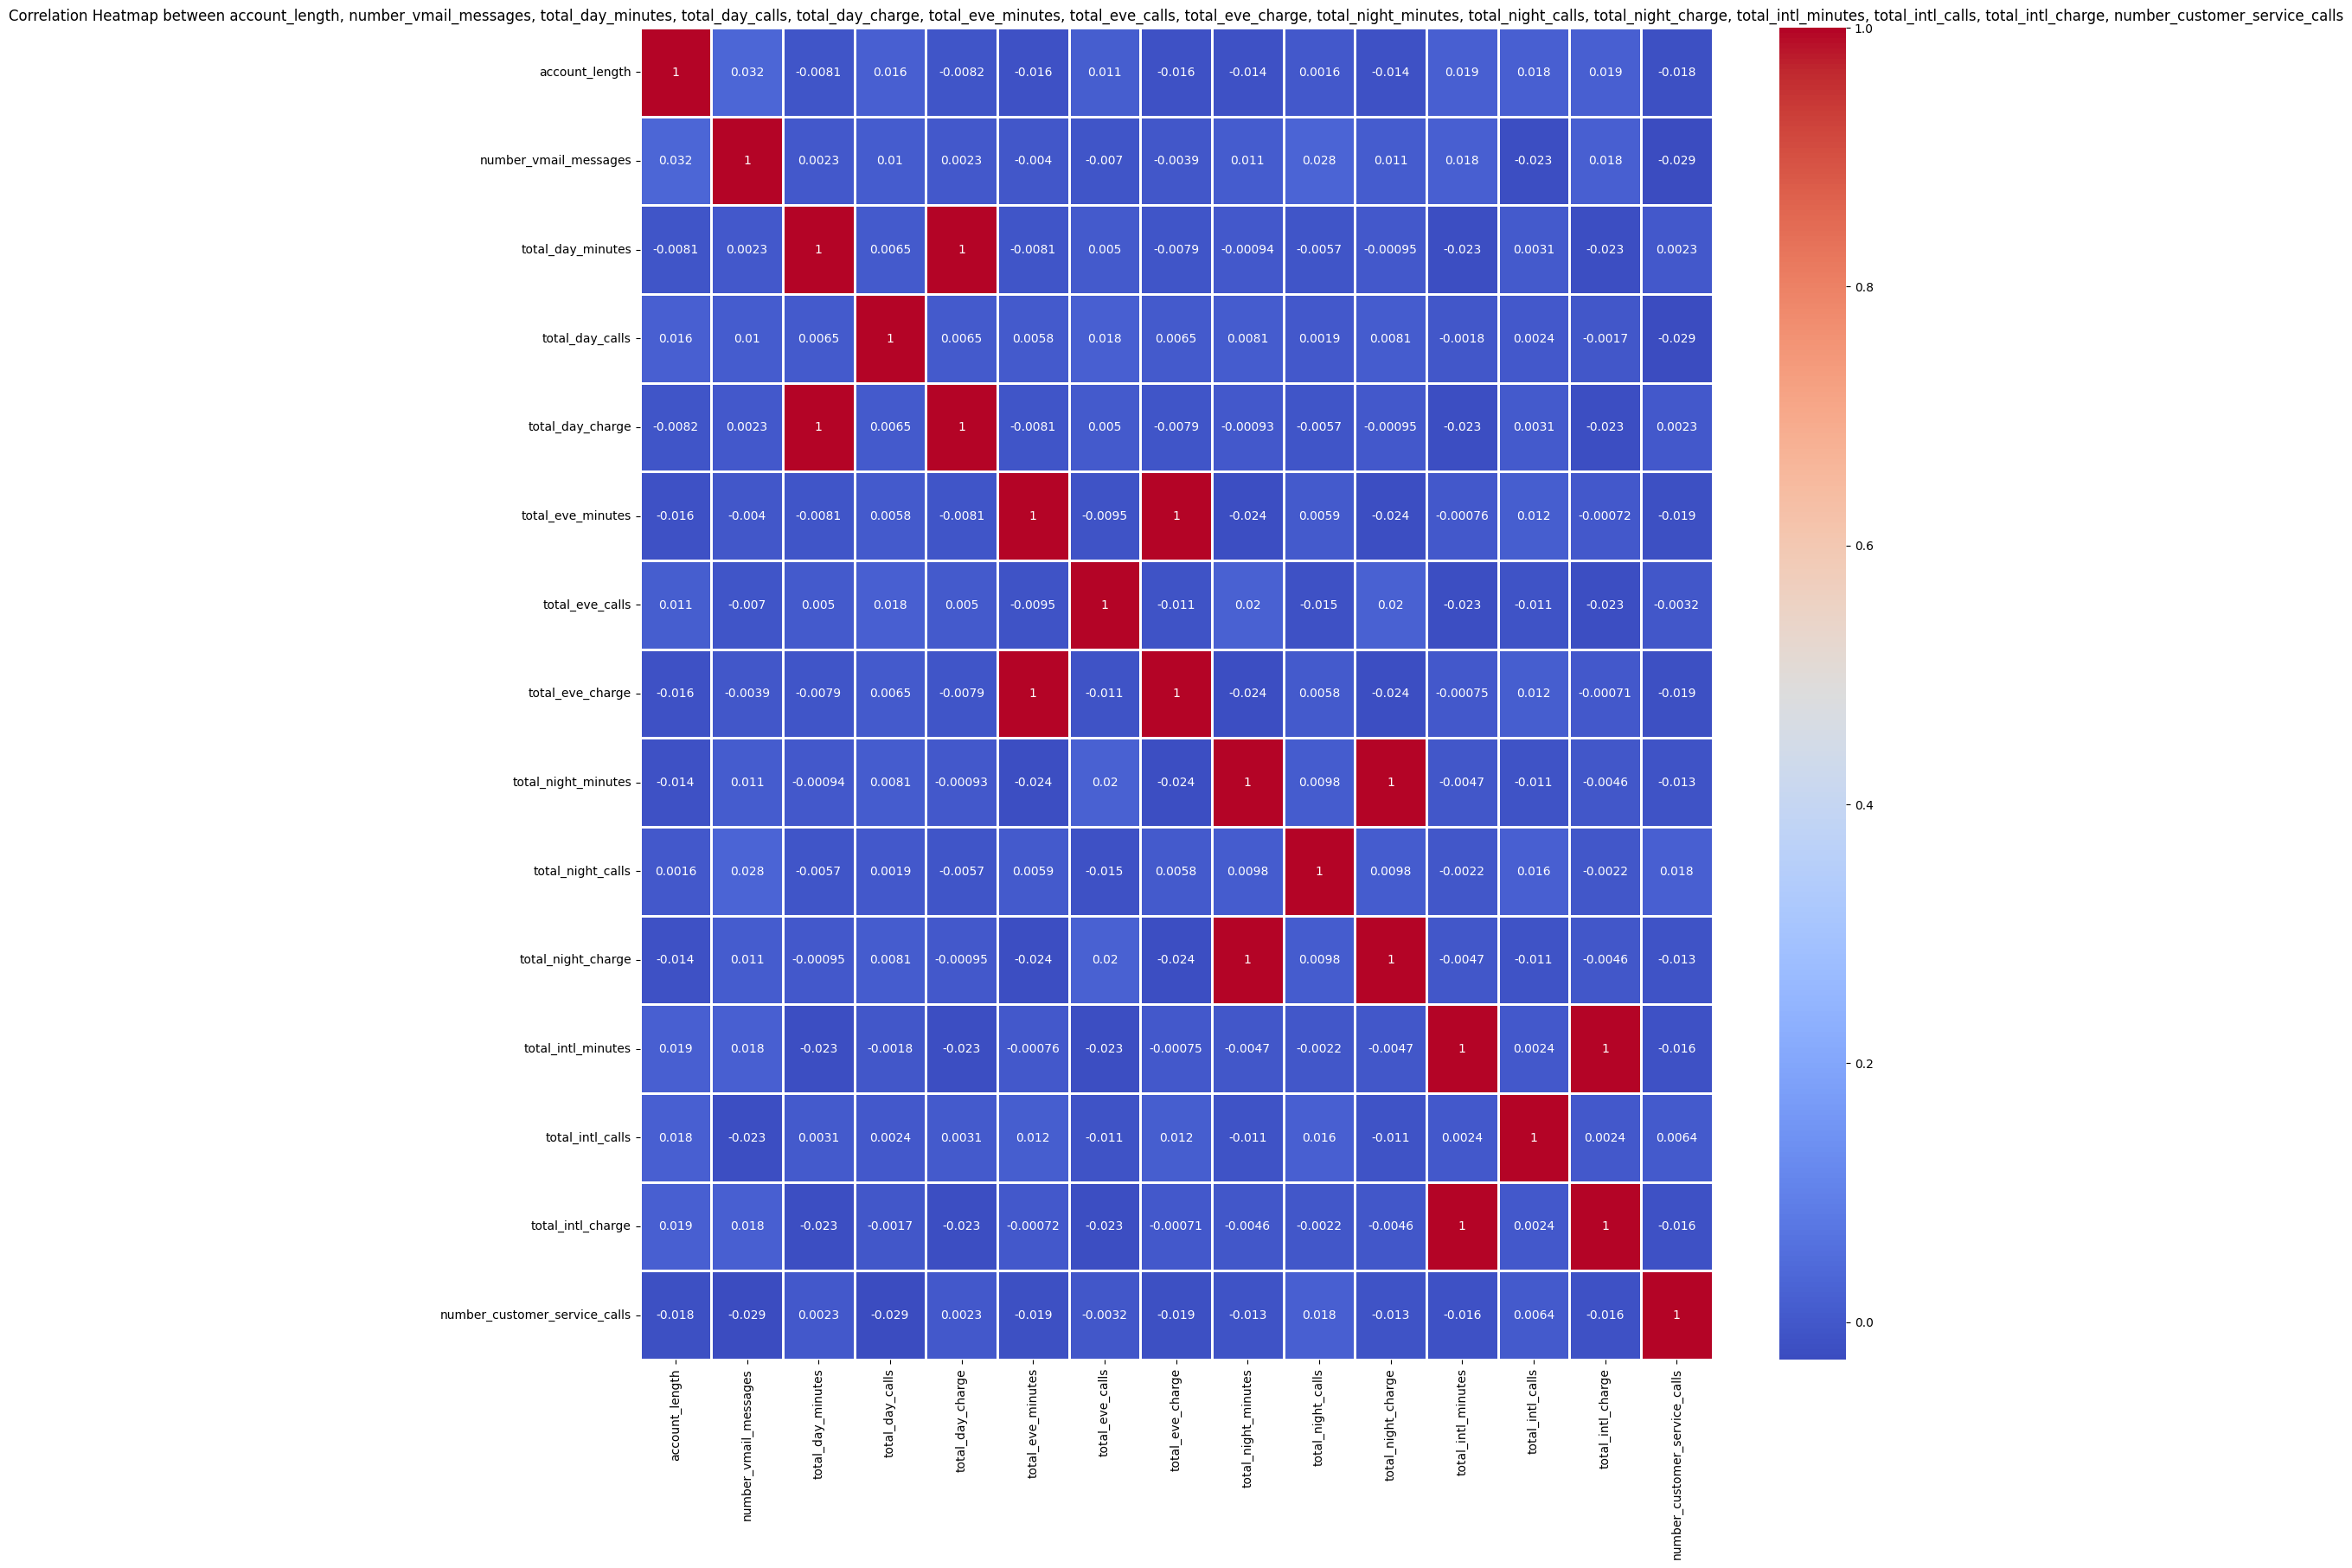

In [ ]:
pdftr=dftr.toPandas()
l=pdftr.select_dtypes(include=['int','float'])
plt.figure(figsize=(20,20))
sns.heatmap(l.corr(), annot=True, cmap='coolwarm', linewidths=1)
plt.title(f'Correlation Heatmap between {", ".join(l)}')
plt.show()

Removal of MultiCollinearity

In [ ]:
dftr=dftr.drop('total_day_charge','total_eve_charge','total_night_charge','total_intl_charge')
dftr.show(5)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+-----------------------------+-----+
|state|account_length|area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_eve_minutes|total_eve_calls|total_night_minutes|total_night_calls|total_intl_minutes|total_intl_calls|number_customer_service_calls|churn|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+-----------------------------+-----+
|   OH|         107.0|      415|                no|            yes|                 26.0|            161.6|          123.0|            195.5|          103.0|              254.4|            103.0| 

Label Encoding

In [ ]:
pdftr=dftr.toPandas()
l = pdftr.select_dtypes(include=['object']).columns.tolist()
for i in l:
    indexer = StringIndexer(inputCol=i, outputCol=i + "_indexed")
    dftr = indexer.fit(dftr).transform(dftr)
    dftr = dftr.drop(i).withColumnRenamed(i+"_indexed",i)

dftr.show(5)

+--------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+-----------------------------+-----+---------+------------------+---------------+-----+
|account_length|number_vmail_messages|total_day_minutes|total_day_calls|total_eve_minutes|total_eve_calls|total_night_minutes|total_night_calls|total_intl_minutes|total_intl_calls|number_customer_service_calls|state|area_code|international_plan|voice_mail_plan|churn|
+--------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+-----------------------------+-----+---------+------------------+---------------+-----+
|         107.0|                 26.0|            161.6|          123.0|            195.5|          103.0|              254.4|            103.0|              13.7|             3.0|                

Feature Engineering

In [ ]:
dftr = dftr.withColumn('total_minutes',
                       dftr['total_day_minutes'] + dftr['total_eve_minutes'] + dftr['total_night_minutes'])

dfte = dfte.withColumn('total_minutes',
                       dfte['total_day_minutes'] + dfte['total_eve_minutes'] + dfte['total_night_minutes'])

dftr = dftr.withColumn('total_calls',
                       dftr['total_day_calls'] + dftr['total_eve_calls'] + dftr['total_night_calls'])

dfte = dfte.withColumn('total_calls',
                       dfte['total_day_calls'] + dfte['total_eve_calls'] + dfte['total_night_calls'])

columns_to_drop = ['state', 'area_code', 'total_day_calls', 'total_eve_calls',
                   'total_night_calls', 'total_day_minutes', 'total_eve_minutes', 'total_night_minutes']

dftr = dftr.drop(*columns_to_drop)
dfte = dfte.drop(*columns_to_drop)


In [ ]:
dftr.show(5)

+--------------+---------------------+------------------+----------------+-----------------------------+------------------+---------------+-----+-------------+-----------+
|account_length|number_vmail_messages|total_intl_minutes|total_intl_calls|number_customer_service_calls|international_plan|voice_mail_plan|churn|total_minutes|total_calls|
+--------------+---------------------+------------------+----------------+-----------------------------+------------------+---------------+-----+-------------+-----------+
|         107.0|                 26.0|              13.7|             3.0|                          1.0|               0.0|            1.0|  0.0|        611.5|      329.0|
|         137.0|                  0.0|              12.2|             5.0|                          0.0|               0.0|            0.0|  0.0|        527.2|      328.0|
|          84.0|                  0.0|               6.6|             7.0|                          2.0|               1.0|            0.0| 

Scaling

In [ ]:
x_sc=dftr.toPandas()

In [ ]:
scale = MinMaxScaler()
df1=pd.DataFrame(scale.fit_transform(x_sc),columns =x_sc.columns)
df1.shape

(4250, 10)

In [ ]:
x=df1.columns.tolist()
assembler = VectorAssembler(inputCols=x, outputCol="features")
x

['account_length',
 'number_vmail_messages',
 'total_intl_minutes',
 'total_intl_calls',
 'number_customer_service_calls',
 'international_plan',
 'voice_mail_plan',
 'churn',
 'total_minutes',
 'total_calls']

In [ ]:
final_data=spark.createDataFrame(df1)

Train test splitting

In [ ]:
train_ratio = 0.8
test_ratio = 0.2
train_data, test_data = final_data.randomSplit([train_ratio, test_ratio], seed=42)
print("Train Data Count:", train_data.count())
print("Test Data Count:", test_data.count())

Train Data Count: 3452
Test Data Count: 798


Correlation with Churn

In [ ]:
numerical_columns = [col_name for col_name, data_type in dftr.dtypes if data_type in ['double', 'float']]
correlations_with_target = {col_name: dftr.corr('churn', col_name) for col_name in numerical_columns}
sorted_correlations = sorted(correlations_with_target.items(), key=lambda x: abs(x[1]), reverse=True)

for col_name, correlation in sorted_correlations:
    print(f"Correlation between {col_name} and {'churn'}: {correlation}")

Correlation between churn and churn: 1.0
Correlation between international_plan and churn: 0.2590529003828174
Correlation between total_minutes and churn: 0.18165655483080279
Correlation between voice_mail_plan and churn: -0.11464257735226926
Correlation between number_vmail_messages and churn: -0.09081883997645544
Correlation between total_intl_calls and churn: -0.05143767093179688
Correlation between total_intl_minutes and churn: 0.0418533205634781
Correlation between number_customer_service_calls and churn: -0.024969529114784016
Correlation between account_length and churn: 0.01232884882919643
Correlation between total_calls and churn: -0.007782362161131304


In [ ]:
final_x = assembler.transform(train_data)
final_test= assembler.transform(test_data)

Model 1: Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(labelCol="churn", featuresCol= 'features')

In [ ]:
pipeline = Pipeline(stages=[rf])

In [ ]:
model = pipeline.fit(final_x)

In [ ]:
predictions = model.transform(final_test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


Stopping the PySpark Session

In [ ]:
spark.stop()